In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import math
from ultralytics import YOLO
import cv2

In [8]:
from court_keypoints import *

In [9]:
# Load the trained model
model = YOLO('./best2.pt')


image 1/1 /Users/lucijaaleksic/Documents/projects/adl-tennis/frames/frame_5.jpg: 384x640 1 Corners, 456.5ms
Speed: 3.9ms preprocess, 456.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
KEYPOINTS [[169.39508056640625, 560.594970703125], [1059.747314453125, 561.9420166015625], [845.3138427734375, 199.73573303222656], [342.3057861328125, 205.403076171875]]
KEYPOINTS [[845.3138427734375, 199.73573303222656], [342.3057861328125, 205.403076171875], [169.39508056640625, 560.594970703125], [1059.747314453125, 561.9420166015625]]
[([342.3057861328125, 205.403076171875], 'Top left corner'), ([845.3138427734375, 199.73573303222656], 'Top right corner'), ([1059.747314453125, 561.9420166015625], 'Bottom right corner'), ([169.39508056640625, 560.594970703125], 'Bottom left corner')]
[((331.7057861328125, 218.803076171875), 'Top left corner'), ((833.7138427734375, 216.13573303222657), 'Top right corner'), ((1073.147314453125, 565.3420166015625), 'Bottom right corner'), ((162.795

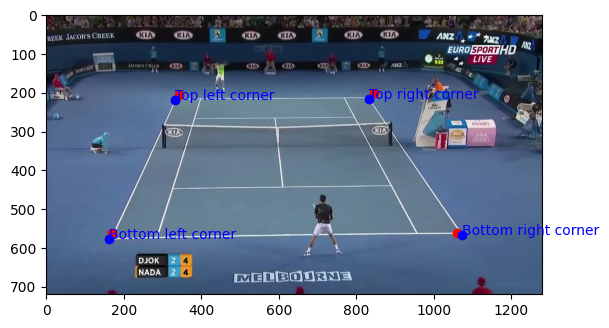

In [10]:
image_path = '/Users/lucijaaleksic/Documents/projects/adl-tennis/frames/frame_5.jpg'  # Replace with your image path
original = Image.open(image_path)

nkps, kps = get_frame_keypoints(model, image_path)
print(kps)
print(nkps)
plt.imshow(original)
for keypoint in kps:
    plt.scatter(keypoint[0][0], keypoint[0][1], color='red')

for new_keypoint, location in nkps:
    plt.scatter(new_keypoint[0], new_keypoint[1], color='blue')
    # add text to the point as location
    plt.text(new_keypoint[0], new_keypoint[1], location, color='blue')
    
plt.show()

## Homography
### Bottom left corner Bottom right corner Top right corner Top left corner

In [11]:
# print(nkps[0][0], nkps[1][0], nkps[2][0], nkps[3][0])
# print(nkps[0][1], nkps[1][1], nkps[2][1], nkps[3][1])

# npk_1 = project_point(nkps[0][0], h)
# npk_2 = project_point(nkps[1][0], h)
# npk_3 = project_point(nkps[2][0], h)
# npk_4 = project_point(nkps[3][0], h)

# print(npk_1, npk_2, npk_3, npk_4)

In [12]:
import numpy as np
from numpy.linalg import inv

# define the keypoints in the tennis court image
court_keypoint1 = (0, 23.78)
court_keypoint2 = (10.97, 23.78)
court_keypoint3 = (10.97, 0)
court_keypoint4 = (0, 0)

In [13]:
nkps

[((331.7057861328125, 218.803076171875), 'Top left corner'),
 ((833.7138427734375, 216.13573303222657), 'Top right corner'),
 ((1073.147314453125, 565.3420166015625), 'Bottom right corner'),
 ((162.79508056640626, 577.994970703125), 'Bottom left corner')]

In [14]:
pts_src = np.array([nkps[0][0], nkps[1][0], nkps[2][0], nkps[3][0]])
pts_dst = np.array([court_keypoint1, court_keypoint2, court_keypoint3, court_keypoint4])

h, _ = cv2.findHomography(pts_src, pts_dst)
h_inv = inv(h)

In [31]:
pts_dst

array([[          0,       23.78],
       [      10.97,       23.78],
       [      10.97,           0],
       [          0,           0]])

In [32]:
pts_src

array([[     331.71,       218.8],
       [     833.71,      216.14],
       [     1073.1,      565.34],
       [      162.8,      577.99]])

In [15]:
def project_point(point, H):
    point = np.array([point[0], point[1], 1.0])  # Convert to homogeneous coordinates
    projected_point = np.dot(H, point)
    projected_point /= projected_point[2]  # Normalize
    return projected_point[:2]  # Return the (x, y) coordinates

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_court(projected_points, projected_player1, projected_player2, ball):
    """
    Visualize a tennis court with keypoints, lines, and net.
    A green background will surround the court by 1m, and a blue rectangle for the tennis court.

    Args:
    - projected_points: A numpy array with the projected keypoints of the court.
                        (expected shape (4, 2) for four corner points).
    """
    # Unpack the projected points for easy access
    projected_keypoint1, projected_keypoint2, projected_keypoint3, projected_keypoint4 = projected_points

    # Calculate the court boundaries (min/max for x and y)
    min_x = min(projected_keypoint1[0], projected_keypoint2[0],
                projected_keypoint3[0], projected_keypoint4[0])
    max_x = max(projected_keypoint1[0], projected_keypoint2[0],
                projected_keypoint3[0], projected_keypoint4[0])
    min_y = min(projected_keypoint1[1], projected_keypoint2[1],
                projected_keypoint3[1], projected_keypoint4[1])
    max_y = max(projected_keypoint1[1], projected_keypoint2[1],
                projected_keypoint3[1], projected_keypoint4[1])

    # Court dimensions
    court_width = 10.97  # Court width in meters
    court_length = 23.78  # Court length in meters
    margin = 3.0         # 1 meter margin around the court

    # Tennis lines based on actual dimensions from the image
    # Service box lengths
    service_box_length = 0.25 * court_length

    # Center service line (length between service boxes)
    center_service_line = court_width / 2.0

    # Net position (middle of the court length)
    net_position = court_length / 2.0

    # Plot the court visualization
    fig, ax = plt.subplots()

    # Plot background in colour (69, 177, 255) with 2m margin
    ax.add_patch(plt.Rectangle((min_x - 2*margin, min_y - 2*margin),
                               max_x - min_x + 4*margin, max_y - min_y + 4*margin,
                               color=(69/255, 177/255, 255/255), alpha=0.5, label='Background'))

    # Plot blue tennis court in colour #156082
    ax.add_patch(plt.Polygon([projected_keypoint1, projected_keypoint2, projected_keypoint3, projected_keypoint4],
                             color='#156082', alpha=0.5, label='Tennis Court'))

    # Plot the net (wide gray line in the middle)
    ax.plot([-1, court_width + 1], [net_position, net_position],
            color='white', linewidth=3, label='Net')

    # Plot the service lines (dashed white lines)
    ax.plot([0, court_width], [service_box_length, service_box_length],
            color='white', label='Service Line')
    
    ax.plot([0, court_width], [court_length - service_box_length, court_length - service_box_length],
        color='white', label='Service Line')
    
# Plot the center service line  
    ax.plot([center_service_line, center_service_line], [service_box_length, court_length - service_box_length], color='white', label='Center Service Line')

    # plot outline of the court
    ax.plot([0, 0], [0, court_length], color='white', label='Court Outline')
    ax.plot([0, court_width], [0, 0], color='white', label='Court Outline')
    ax.plot([court_width, court_width], [0, court_length], color='white', label='Court Outline')
    ax.plot([0, court_width], [court_length, court_length], color='white', label='Court Outline')

    # plot the players
    projected_player1[1] = court_length - projected_player1[1]
    ax.scatter(projected_player1[0], projected_player1[1], color='red', label='Player 1')

    # reverse coordinates
    projected_player2[1] = court_length - projected_player2[1]
    ax.scatter(projected_player2[0], projected_player2[1], color='blue', label='Player 2')

    # plot the ball
    ax.scatter(ball[0], ball[1], color='yellow', label='Ball')

    # Label and plot details
    ax.set_title("Tennis Court Visualization with Net and Lines")
    ax.set_xlabel("Court Width (meters)")
    ax.set_ylabel("Court Length (meters)")

    # Set axis limits with some margin
    ax.set_xlim(min_x - margin - 1, max_x + margin + 1)
    ax.set_ylim(min_y - margin - 1, max_y + margin + 1)

    # Equal aspect ratio
    ax.set_aspect('equal')

    # legend off
    ax.legend().set_visible(False)

    # Show the plot
    plt.show()

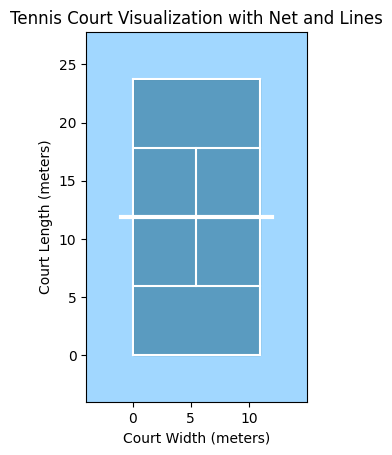

In [17]:
visualize_court(pts_dst, project_point((0, 0), h), project_point((200, 4000), h), project_point((1500, 2000), h))

## Human detection

In [18]:
image_path = '/Users/lucijaaleksic/Documents/projects/adl-tennis/frames/frame_5.jpg'
yolo_model = YOLO('./yolov5s.pt')

PRO TIP 💡 Replace 'model=./yolov5s.pt' with new 'model=./yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.




image 1/1 /Users/lucijaaleksic/Documents/projects/adl-tennis/frames/frame_5.jpg: 384x640 1 Corners, 987.2ms
Speed: 10.7ms preprocess, 987.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
KEYPOINTS [[169.39508056640625, 560.594970703125], [1059.747314453125, 561.9420166015625], [845.3138427734375, 199.73573303222656], [342.3057861328125, 205.403076171875]]
KEYPOINTS [[845.3138427734375, 199.73573303222656], [342.3057861328125, 205.403076171875], [169.39508056640625, 560.594970703125], [1059.747314453125, 561.9420166015625]]
[((331.7057861328125, 218.803076171875), 'Top left corner'), ((833.7138427734375, 216.13573303222657), 'Top right corner'), ((1073.147314453125, 565.3420166015625), 'Bottom right corner'), ((162.79508056640626, 577.994970703125), 'Bottom left corner')]
Top left corner
Top right corner
Bottom right corner
Bottom left corner


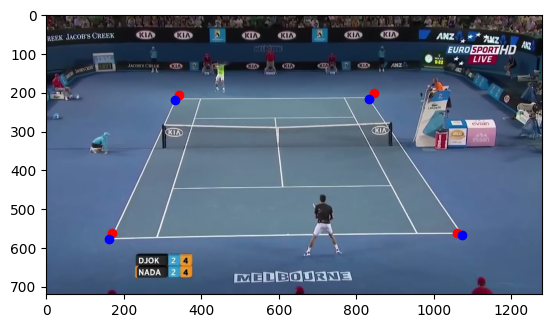

In [20]:
original = Image.open(image_path)

nkps, kps = get_frame_keypoints(model, image_path)
print(nkps)
plt.imshow(original)
for keypoint in kps:
    plt.scatter(keypoint[0][0], keypoint[0][1], color='red')

for new_keypoint, location in nkps:
    print(location)
    plt.scatter(new_keypoint[0], new_keypoint[1], color='blue')
plt.show()

In [21]:
results = yolo_model(image_path)
results[0].save("people.jpg")


image 1/1 /Users/lucijaaleksic/Documents/projects/adl-tennis/frames/frame_5.jpg: 384x640 13 persons, 148.3ms
Speed: 3.2ms preprocess, 148.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


'people.jpg'

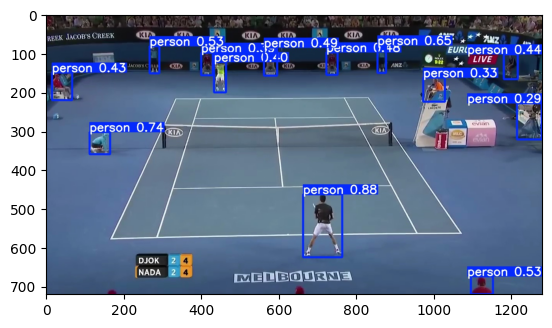

In [22]:
output_path = "people.jpg"
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image = Image.open(output_path)
plt.imshow(image)
plt.show()

In [23]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
conf: tensor([0.8848, 0.7418, 0.6458, 0.5310, 0.5276, 0.4907, 0.4777, 0.4404, 0.4301, 0.3971, 0.3886, 0.3320, 0.2926])
data: tensor([[6.6376e+02, 4.6338e+02, 7.6401e+02, 6.2583e+02, 8.8478e-01, 0.0000e+00],
        [1.1273e+02, 3.0330e+02, 1.6547e+02, 3.6025e+02, 7.4178e-01, 0.0000e+00],
        [8.5515e+02, 8.0937e+01, 8.7734e+02, 1.5123e+02, 6.4581e-01, 0.0000e+00],
        [2.6716e+02, 8.2355e+01, 2.9213e+02, 1.5295e+02, 5.3102e-01, 0.0000e+00],
        [1.0967e+03, 6.7486e+02, 1.1535e+03, 7.2000e+02, 5.2764e-01, 0.0000e+00],
        [5.6240e+02, 8.6016e+01, 5.9619e+02, 1.5833e+02, 4.9068e-01, 0.0000e+00],
        [7.2301e+02, 9.8772e+01, 7.5266e+02, 1.5677e+02, 4.7773e-01, 0.0000e+00],
        [1.1815e+03, 1.0347e+02, 1.2172e+03, 1.6706e+02, 4.4044e-01, 0.0000e+00],
        [1.5895e+01, 1.5031e+02, 6.7504e+01, 2.2123e+02, 4.3010e-01, 0.0000e+00],
        [4.33

tensor([663.7645, 463.3799, 764.0146, 625.8300,   0.8848,   0.0000])
tensor([112.7286, 303.2960, 165.4724, 360.2546,   0.7418,   0.0000])
tensor([8.5515e+02, 8.0937e+01, 8.7734e+02, 1.5123e+02, 6.4581e-01, 0.0000e+00])
tensor([267.1600,  82.3550, 292.1312, 152.9510,   0.5310,   0.0000])
tensor([1.0967e+03, 6.7486e+02, 1.1535e+03, 7.2000e+02, 5.2764e-01, 0.0000e+00])
tensor([5.6240e+02, 8.6016e+01, 5.9619e+02, 1.5833e+02, 4.9068e-01, 0.0000e+00])
tensor([7.2301e+02, 9.8772e+01, 7.5266e+02, 1.5677e+02, 4.7773e-01, 0.0000e+00])
tensor([1.1815e+03, 1.0347e+02, 1.2172e+03, 1.6706e+02, 4.4044e-01, 0.0000e+00])
tensor([ 15.8950, 150.3081,  67.5041, 221.2329,   0.4301,   0.0000])
tensor([4.3337e+02, 1.2366e+02, 4.6414e+02, 2.0114e+02, 3.9713e-01, 0.0000e+00])
tensor([4.0054e+02, 9.9508e+01, 4.3016e+02, 1.5798e+02, 3.8861e-01, 0.0000e+00])
tensor([9.7325e+02, 1.6315e+02, 1.0291e+03, 2.2533e+02, 3.3201e-01, 0.0000e+00])
tensor([1.2153e+03, 2.2920e+02, 1.2794e+03, 3.2255e+02, 2.9255e-01, 0.0000e+

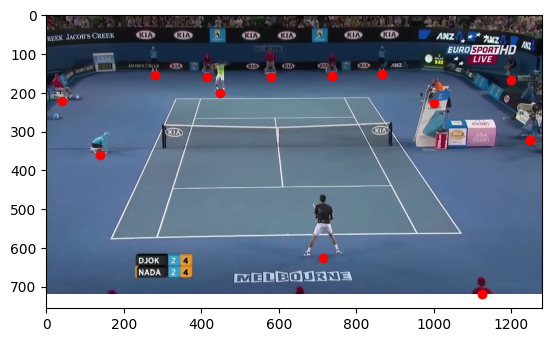

In [24]:
people_positions = []
for box in results[0].boxes.data:
    print(box)
    x1, y1, x2, y2, _, _ = box
    center_x = (x1 + x2) / 2
    center_y = y2
    people_positions.append((center_x, center_y))

img = Image.open(image_path)
plt.imshow(img)
for position in people_positions:
    plt.scatter(position[0], position[1], color='red')
plt.show()

In [25]:
# Bottom left corner
# Bottom right corner
# Top right corner
# Top left corner

In [26]:
def pDistance(point, line1, line2):
    """
    Calculate the shortest distance from a point (x, y) to a line segment (x1, y1) to (x2, y2).
    
    Parameters:
        x, y: Coordinates of the point.
        x1, y1: Coordinates of the first endpoint of the line segment.
        x2, y2: Coordinates of the second endpoint of the line segment.
    
    Returns:
        The shortest distance from the point to the line segment.
    """
    x, y = point
    x1, y1 = line1
    x2, y2 = line2
    
    A = x - x1
    B = y - y1
    C = x2 - x1
    D = y2 - y1

    dot = A * C + B * D
    len_sq = C * C + D * D
    param = -1

    if len_sq != 0:  # In case of a non-zero length line segment
        param = dot / len_sq

    if param < 0:
        xx, yy = x1, y1
    elif param > 1:
        xx, yy = x2, y2
    else:
        xx = x1 + param * C
        yy = y1 + param * D

    dx = x - xx
    dy = y - yy
    return math.sqrt(dx * dx + dy * dy)

Top baseline: [(331.7057861328125, 218.803076171875), (833.7138427734375, 216.13573303222657)]
Bottom baseline: [(162.79508056640626, 577.994970703125), (1073.147314453125, 565.3420166015625)]
[(tensor(713.8896), tensor(625.8300)), (tensor(448.7532), tensor(201.1422))]
(tensor(713.8896), tensor(625.8300))
(tensor(448.7532), tensor(201.1422))


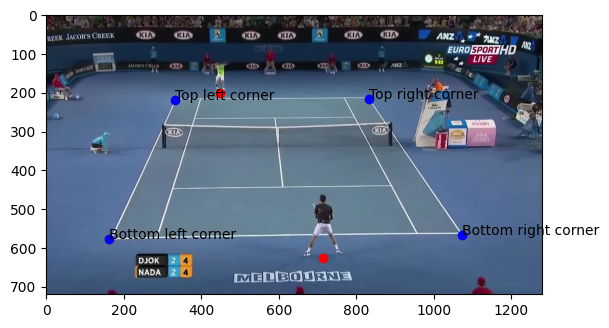

In [34]:
# take two people closest to the new keypoints of the court
def closest_people(people_positions, new_keypoints):
    closest_people = []
    baseline_top = []
    baseline_bottom = []
    for new_keypoint, location in new_keypoints:
        if "Bottom" in location:
            baseline_bottom.append(new_keypoint)
        else:
            baseline_top.append(new_keypoint)
    # sort the baselines points by x
    baseline_top = sorted(baseline_top, key=lambda x: x[0])
    baseline_bottom = sorted(baseline_bottom, key=lambda x: x[0])
    print("Top baseline:", baseline_top)
    print("Bottom baseline:", baseline_bottom)

    # find closest person to the bottom baseline
    min_distance = math.inf
    closest_person = None
    for person in people_positions:
        distance = pDistance(person, baseline_bottom[0], baseline_bottom[1])
        if distance < min_distance:
            min_distance = distance
            closest_person = person
    closest_people.append(closest_person)

    # find closest person to the top baseline
    min_distance = math.inf
    closest_person = None
    for person in people_positions:
        distance = pDistance(person, baseline_top[0], baseline_top[1])
        if distance < min_distance:
            min_distance = distance
            closest_person = person
    closest_people.append(closest_person)

    return closest_people

players = closest_people(people_positions, nkps)
print(players)
plt.imshow(img)
for keypoint, location in nkps:
    plt.scatter(keypoint[0], keypoint[1], color='blue')
    plt.text(keypoint[0], keypoint[1], location)
    
for position in players:
    print(position)
    plt.scatter(position[0], position[1], color='red')
plt.show()

In [28]:
print(nkps[0][0], nkps[1][0], nkps[2][0], nkps[3][0])
print(nkps[0][1], nkps[1][1], nkps[2][1], nkps[3][1])

npk_1 = project_point(nkps[0][0], h)
npk_2 = project_point(nkps[1][0], h)
npk_3 = project_point(nkps[2][0], h)
npk_4 = project_point(nkps[3][0], h)

print(npk_1, npk_2, npk_3, npk_4)

(331.7057861328125, 218.803076171875) (833.7138427734375, 216.13573303222657) (1073.147314453125, 565.3420166015625) (162.79508056640626, 577.994970703125)
Top left corner Top right corner Bottom right corner Bottom left corner
[ 1.9421e-07       23.78] [      10.97       23.78] [      10.97   9.245e-07] [-6.3801e-08  8.8884e-07]


In [30]:
h

array([[    0.04301,    0.020226,     -18.692],
       [ -0.0018407,    -0.13243,      76.846],
       [-2.3648e-05,   0.0045482,           1]])

[     6.4421     -1.9191] [     2.4561      25.933]


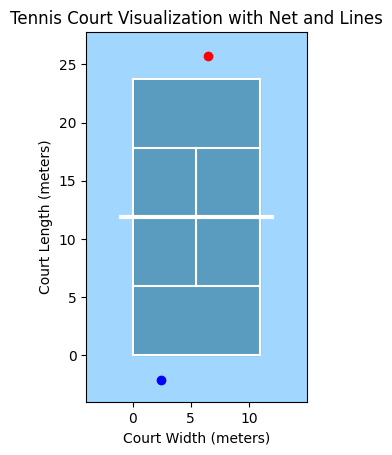

In [29]:
player_1_projected = project_point(players[0], h)
player_2_projected = project_point(players[1], h)
print(player_1_projected, player_2_projected)
ball_projected = project_point((1500, 2000), h)

visualize_court(pts_dst, player_1_projected, player_2_projected, ball_projected)

## Image masking

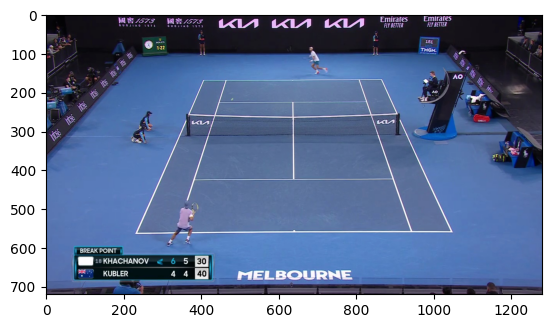

In [ ]:
image = cv2.imread("/Users/lucijaaleksic/Documents/projects/adl-tennis/frames/frame_140.jpg")

# Step 1: Convert to HSV for color segmentation
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(hsv_image)
plt.show()

In [ ]:
lower_blue = np.array([100, 150, 50])
upper_blue = np.array([140, 255, 255])

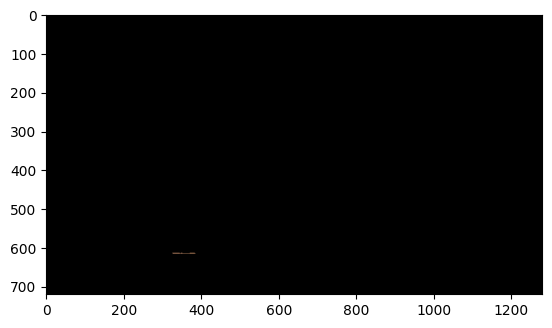

In [ ]:
court_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

# Step 4: Find contours of the masked court
contours, _ = cv2.findContours(court_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Create a mask from the largest contour (assuming the largest contour is the court)
mask = np.zeros_like(image)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

# Step 6: Apply the mask to the image
masked_image = cv2.bitwise_and(image, mask)

plt.imshow(masked_image)
plt.show()